# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [4]:
import sys
sys.path.append('../')

In [5]:
import neptune

In [16]:
## download from neptune
LOC_START_ID, LOC_END_ID = 1180, 1367
LOC_SKIP_IDS = []
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]

In [8]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")

In [19]:
def fetch_metadata(run_id: str) -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBSCAN-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBSCAN-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}, RUN_ID: {run_id}"

        metric = run["scores"]["metric"].fetch()
        ac2 = metric["AC_2"]
        ac5 = metric["AC_5"]
        avg5 = metric["AVG_5"]
        elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
        return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction, "localization_method": localization,
                    "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}

In [21]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run) for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1194
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1208
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1183
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1211
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1206
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1217
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1190
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1223
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1199
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1188
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1195
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1215
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1180
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1191
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1218
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1200
https://

In [22]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    display(loc_tsdr_df.set_index(["dataset", "reduction_method", "localization_method"]).sort_index())

ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.172840  0.209877  0.197737   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.154321  0.219753  0.182428   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          HDBSCAN-R        CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.240741  0.170370  0.223786   
                           e-Diagnosis          0.000000  0.002469  0.000494   
          HDBSCAN-SBD      CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.203704  0.170370  0.198477   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          K-S test         CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.154321  0.214815  0.180617   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          NSigma           CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.148148  0.212346  0.177654   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          None             CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.160494  0.214815  0.186379   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          TSifter          CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.181818  0.215584  0.198745   
                           e-Diagnosis          0.012987  0.012987  0.012987   
SS-medium BIRCH            CG+PageRank          0.024691  0.019753  0.022263   
                           RCD                  0.629630  0.624691  0.623292   
                           e-Diagnosis          0.006173  0.014815  0.009753   
          FluxInfer-AD     CG+PageRank          0.037037  0.034568  0.039218   
                           RCD                  0.617284  0.604938  0.604321   
                           e-Diagnosis          0.018519  0.022222  0.017613   
          HDBSCAN-R        CG+PageRank          0.030864  0.049383  0.035802   
                           RCD                  0.530864  0.340741  0.467737   
                           e-Diagnosis          0.024691  0.041975  0.028148   
          HDBSCAN-SBD      CG+PageRank          0.049383  0.064198  0.055432   
                           RCD                  0.598765  0.360494  0.509136   
                           e-Diagnosis          0.012346  0.037037  0.022428   
          K-S test         CG+PageRank          0.037037  0.037037  0.035185   
                           RCD                  0.611111  0.614815  0.613086   
                           e-Diagnosis          0.018519  0.022222  0.017613   
          NSigma           CG+PageRank          0.055556  0.056790  0.060741   
                           RCD                  0.629630  0.622222  0.616214   
                           e-Diagnosis          0.018519  0.019753  0.017942   
          None             CG+PageRank          0.055556  0.056790  0.060741   
                           RCD                  0.604938  0.632099  0.610165   
                           e-Diagnosis          0.006173  0.012346  0.008642   
          TSifter          CG+PageRank          0.031646  0.053165  0.040802   
                           RCD                  0.696203  0.681013  0.680506   
                           e-Diagnosis          0.151899  0.139241  0.159705   
SS-small  BIRCH            CG+PageRank          0.08

## Load tsdr

In [23]:
TSDR_START_ID, TSDR_END_ID = 793, 840
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]

In [90]:
def fetch_metadata_of_tsdr(run_id: str) -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBSCAN-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBSCAN-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        scores = run["scores"].fetch()
        frr = scores["reduction_rate_mean"]
        rfr = scores["cause_metrics"]["recall_mandatory_mean"]
        rfp = scores["cause_metrics"]["proportion_mandatory_mean"]
        num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
        num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
        elapsed_time = scores["elapsed_time"]
        return {
            "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
            "reduction_method": reduction,
            "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
            "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
            "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
        }

In [91]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run) for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-810
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-816
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-802
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-798
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-818
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-814
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-817
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-806
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-803
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-805
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-804
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-794
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-801
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-807
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-810/metadata
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-812
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-797
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-799
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-796
https://app.neptune.ai/yuuk1/tsdr/

In [305]:
def create_table_dataframe_multi_level(
    items: list[dict[str, str|float]],
    first_levels: list[str], second_levels: list[str], first_level_key: str, second_level_key: str, first_label: str, second_label: str,
    columns: list[str],
) -> pd.DataFrame:
    multi_level_indexes = pd.MultiIndex.from_product(
        [first_levels, second_levels], names=[first_label, second_label])
    multi_level_cols = pd.MultiIndex.from_product([first_levels, columns], names=['', ''])
    df = pd.DataFrame(items).set_index([first_level_key, second_level_key]).reindex(index=multi_level_indexes)
    df = df.unstack(first_label)
    df = df.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=second_levels, columns=multi_level_cols,
    )
    return df

from itertools import product

def to_latex_table(table_df: pd.DataFrame, first_levels: list[str], second_levels: list[str], columns: list[str], highlight_max_columns: list[str], highlight_min_columns: list[str]) -> str:
    styler = table_df[product(first_levels, columns)].style
    styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
    styler.format({k: '{:.4f}' for k in product(first_levels, ["RFP"])}, precision=3)
    return styler.to_latex(hrules=True)

In [301]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBSCAN-SBD", "HDBSCAN-R", "TSifter"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

In [308]:
ss_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=ss_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ss_table_df)

print(
    to_latex_table(ss_table_df, ss_datasets, reduction_methods, metrics, ["FRR", "RFR", "RFP"], ["elapsed_time"])
)

SS-small                                SS-medium            \
                       FRR     RFR       RFP elapsed_time       FRR       RFR   
Reduction Method                                                                
None              0.000000  1.0000  0.015518     0.276380  0.000000  1.000000   
NSigma            0.128410  0.9875  0.017695     0.537260  0.174410  0.987500   
BIRCH             0.156613  1.0000  0.018698     0.353011  0.181778  1.000000   
K-S test          0.130166  1.0000  0.018141     0.558450  0.133890  1.000000   
FluxInfer-AD      0.130166  1.0000  0.018141     0.566260  0.133890  1.000000   
HDBSCAN-SBD       0.458552  0.4250  0.012174     0.615068  0.689923  0.247083   
HDBSCAN-R         0.459161  0.4000  0.011460     0.650790  0.694884  0.234583   
TSifter           0.355634  0.9125  0.023763     0.803499  0.468055  0.920833   

                                         SS-large                      \
                       RFP elapsed_time       FRR       RFR       RFP   
Reduction Method                                                        
None              0.023744     0.293380  0.000000  1.000000  0.004991   
NSigma            0.028192     0.574358  0.316506  0.962538  0.006918   
BIRCH             0.029020     0.394243  0.239872  0.976174  0.006328   
K-S test          0.027427     0.601738  0.118534  0.996875  0.005626   
FluxInfer-AD      0.027427     0.622737  0.118534  0.996875  0.005626   
HDBSCAN-SBD       0.018738     0.705545  0.843256  0.135685  0.003975   
HDBSCAN-R         0.018147     0.944539  0.836142  0.138511  0.003810   
TSifter           0.043231     1.004181  0.554197  0.804521  0.008671   

                               
                 elapsed_time  
Reduction Method               
None                 0.431810  
NSigma               1.082570  
BIRCH                0.905643  
K-S test             1.144316  
FluxInfer-AD         1.150177  
HDBSCAN-SBD          5.701363  
HDBSCAN-R           75.128691  
TSifter              3.054405

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.0155 & \textbf{0.276} & 0.000 & \textbf{1.000} & 0.0237 & \textbf{0.293} & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.432} \\
NSigma & 0.128 & 0.988 & 0.0177 & 0.537 & 0.174 & 0.988 & 0.0282 & 0.574 & 0.317 & 0.963 & 0.0069 & 1.083 \\
BIRCH & 0.157 & \textbf{1.000} & 0.0187 & 0.353 & 0.182 & \textbf{1.000} & 0.0290 & 0.394 & 0.240 & 0.976 & 0.0063 & 0.906 \\
K-S test & 0.130 & \textbf{1.000} & 0.0181 & 0.558 & 0.134 & \textbf{1.000} & 0.0274 & 0.602 & 0.119 & 0.997 & 0.0056 & 1.144 \\
FluxInfer-AD & 0.130 & \textbf{1.000} & 0.0181 & 0.566 & 0.134 & \textbf{1.000} & 0.0274 & 0.623 & 0.119 & 0.997 & 0.0056 & 1.150 \\
HDBSCAN-SBD & 0.459 & 0.425 & 0.0122

In [309]:
tt_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=tt_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(tt_table_df)

print(
    to_latex_table(tt_table_df, tt_datasets, reduction_methods, metrics, ["FRR", "RFR", "RFP"], ["elapsed_time"])
)

TT-small                                  TT-medium  \
                       FRR       RFR       RFP elapsed_time       FRR   
Reduction Method                                                        
None              0.000000  1.000000  0.003078     0.964681  0.000000   
NSigma            0.289648  1.000000  0.004373     1.996367  0.327328   
BIRCH             0.263016  0.976190  0.004080     1.174450  0.267093   
K-S test          0.274108  1.000000  0.004308     1.918581  0.261482   
FluxInfer-AD      0.274108  1.000000  0.004308     2.063774  0.261482   
HDBSCAN-SBD       0.523989  0.357143  0.002180     2.299064  0.742595   
HDBSCAN-R         0.525968  0.571429  0.003765     2.247726  0.741878   
TSifter           0.567204  0.880952  0.006246     3.196355  0.674851   

                                                   TT-large            \
                       RFR       RFP elapsed_time       FRR       RFR   
Reduction Method                                                        
None              1.000000  0.003429     1.016921  0.000000  1.000000   
NSigma            1.000000  0.005083     2.288860  0.467522  0.997024   
BIRCH             1.000000  0.004661     1.515700  0.353294  1.000000   
K-S test          1.000000  0.004619     2.382055  0.241357  0.996032   
FluxInfer-AD      1.000000  0.004619     2.388426  0.241357  0.996032   
HDBSCAN-SBD       0.173810  0.002493     3.025990  0.854127  0.135629   
HDBSCAN-R         0.173810  0.002491     3.607157  0.845956  0.129110   
TSifter           0.948413  0.010057     4.892048  0.710454  0.722222   

                                         
                       RFP elapsed_time  
Reduction Method                         
None              0.000726     2.041240  
NSigma            0.001365     5.810788  
BIRCH             0.001123     4.871833  
K-S test          0.000956     5.996076  
FluxInfer-AD      0.000956     6.058931  
HDBSCAN-SBD       0.000681    14.628286  
HDBSCAN-R         0.000626    97.571105  
TSifter           0.001788    23.780614

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.965} & 0.000 & \textbf{1.000} & 0.0034 & \textbf{1.017} & 0.000 & \textbf{1.000} & 0.0007 & \textbf{2.041} \\
NSigma & 0.290 & \textbf{1.000} & 0.0044 & 1.996 & 0.327 & \textbf{1.000} & 0.0051 & 2.289 & 0.468 & 0.997 & 0.0014 & 5.811 \\
BIRCH & 0.263 & 0.976 & 0.0041 & 1.174 & 0.267 & \textbf{1.000} & 0.0047 & 1.516 & 0.353 & \textbf{1.000} & 0.0011 & 4.872 \\
K-S test & 0.274 & \textbf{1.000} & 0.0043 & 1.919 & 0.261 & \textbf{1.000} & 0.0046 & 2.382 & 0.241 & 0.996 & 0.0010 & 5.996 \\
FluxInfer-AD & 0.274 & \textbf{1.000} & 0.0043 & 2.064 & 0.261 & \textbf{1.000} & 0.0046 & 2.388 & 0.241 & 0.996 & 0.0010 & 6.059 \\
HDBSCAN-SBD & 0.52

## Join tsdr and localization

In [33]:
loc_rs_df = loc_tsdr_df.copy()
loc_rs_df = pd.DataFrame([
    {"dataset": dataset, "localization_method": "RS", "reduction_method": reduction_method, "ac@2": _ac_2, "ac@5": _ac_5, "avg@5": _avg_5} for (dataset, reduction_method), _ac_2, _ac_5, _avg_5 in zip(itertools.product(datasets, reduction_methods), tsdr_df["rs_ac@2"], tsdr_df["rs_ac@5"], tsdr_df["rs_avg@5"])
])
loc_rs_df.query("localization_method == 'RS'")

,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5
0,SS-small,RS,None,0.030796,0.075220,0.045602
1,SS-small,RS,NSigma,0.035070,0.085335,0.051823
2,SS-small,RS,BIRCH,0.037040,0.089998,0.054691
3,SS-small,RS,K-S test,0.035947,0.087413,0.053100
4,SS-small,RS,FluxInfer-AD,0.035947,0.087413,0.053100
5,SS-small,RS,HDBSCAN-SBD,0.024000,0.057483,0.035158
6,SS-small,RS,HDBSCAN-R,0.022592,0.054110,0.033095
7,SS-small,RS,TSifter,0.046833,0.112108,0.068584
8,SS-medium,RS,None,0.046866,0.112670,0.068795
9,SS-medium,RS,NSigma,0.055516,0.132568,0.081191


In [34]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df])

In [66]:
joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_df, how="inner", on=['dataset', 'reduction_method'], lsuffix='_loc', rsuffix='_tsdr')
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
    display(
        joined_df.reset_index().set_index(['dataset', 'localization_method', 'reduction_method']).sort_index()
    )

ac@2   ac@5  avg@5  \
dataset   localization_method reduction_method                        
SS-large  CG+PageRank         BIRCH            0.0000 0.0000 0.0000   
                              FluxInfer-AD     0.0000 0.0000 0.0000   
                              HDBSCAN-R        0.0000 0.0000 0.0000   
                              HDBSCAN-SBD      0.0000 0.0000 0.0000   
                              K-S test         0.0000 0.0000 0.0000   
                              NSigma           0.0000 0.0000 0.0000   
                              None             0.0000 0.0000 0.0000   
                              TSifter          0.0000 0.0000 0.0000   
          RCD                 BIRCH            0.1728 0.2099 0.1977   
                              FluxInfer-AD     0.1543 0.2198 0.1824   
                              HDBSCAN-R        0.2407 0.1704 0.2238   
                              HDBSCAN-SBD      0.2037 0.1704 0.1985   
                              K-S test         0.1543 0.2148 0.1806   
                              NSigma           0.1481 0.2123 0.1777   
                              None             0.1605 0.2148 0.1864   
                              TSifter          0.1818 0.2156 0.1987   
          RS                  BIRCH            0.0126 0.0312 0.0188   
                              FluxInfer-AD     0.0112 0.0278 0.0167   
                              HDBSCAN-R        0.0076 0.0188 0.0113   
                              HDBSCAN-SBD      0.0079 0.0196 0.0118   
                              K-S test         0.0112 0.0278 0.0167   
                              NSigma           0.0138 0.0341 0.0205   
                              None             0.0100 0.0247 0.0149   
                              TSifter          0.0173 0.0425 0.0257   
          e-Diagnosis         BIRCH            0.0000 0.0000 0.0000   
                              FluxInfer-AD     0.0000 0.0000 0.0000   
                              HDBSCAN-R        0.0000 0.0025 0.0005   
                              HDBSCAN-SBD      0.0000 0.0000 0.0000   
                              K-S test         0.0000 0.0000 0.0000   
                              NSigma           0.0000 0.0000 0.0000   
                              None             0.0000 0.0000 0.0000   
                              TSifter          0.0130 0.0130 0.0130   
SS-medium CG+PageRank         BIRCH            0.0247 0.0198 0.0223   
                              FluxInfer-AD     0.0370 0.0346 0.0392   
                              HDBSCAN-R        0.0309 0.0494 0.0358   
                              HDBSCAN-SBD      0.0494 0.0642 0.0554   
                              K-S test         0.0370 0.0370 0.0352   
                              NSigma           0.0556 0.0568 0.0607   
                              None             0.0556 0.0568 0.0607   
                              TSifter          0.0316 0.0532 0.0408   
          RCD                 BIRCH            0.6296 0.6247 0.6233   
                              FluxInfer-AD     0.6173 0.6049 0.6043   
                              HDBSCAN-R        0.5309 0.3407 0.4677   
                              HDBSCAN-SBD      0.5988 0.3605 0.5091   
                              K-S test         0.6111 0.6148 0.6131   
                              NSigma           0.6296 0.6222 0.6162   
                              None             0.6049 0.6321 0.6102   
                              TSifter          0.6962 0.6810 0.6805   
          RS                  BIRCH            0.0571 0.1362 0.0835   
                              FluxInfer-AD     0.0540 0.1291 0.0790   
                              HDBSCAN-R        0.0359 0.0865 0.0528   
                              HDBSCAN-SBD      0.0370 0.0892 0.0544   
                              K-S test         0.0540 0.1291 0.0790   
                              NSigma           0.0555 0.1326 0.0812   
                              None             0.0469 0.1127 0.0688   
  

In [58]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBSCAN-\nSBD"
        case "HDBSCAN-R":
            return "HDBSCAN-R"
    return label


def plot_combination(dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            bar = sns.barplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods, dodge=True,
                color="none", fill=None,
                ax=ax,
            )
            hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:len(loc_methods)]
            # for bar, hatch in zip(bar.patches, sum([[h] * len(reduction_methods) for h in hatchs], [])):
            #     bar.set_hatch(hatch)
            for container, hatch, handle, color in zip(
                ax.containers, hatchs, ax.get_legend().legend_handles, sns.color_palette(),
            ):
                handle.set_hatch(hatch)
                handle.set_edgecolor(color)
                for rectangle in container:
                    rectangle.set_hatch(hatch)
                    rectangle.set_edgecolor(color)
        case "point":
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"][0:len(loc_methods)]
            line = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=False, markers=markers, linestyles=linestyles, scale=0.8,
                ax=ax,
            )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel(ylabel)
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(dataset: str, loc_methods: list[str]):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_loc", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel("AC@5")
    ax2.set_ylabel("T(s)")
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")


# def plot_localization_perf_by_loc_method(loc_method: str):
#     data = joined_df.reset_index().query("localization_method == @loc_method")

#     fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
#     ax2 = ax1.twinx()
#     sns.barplot(
#         data=data, x="reduction_method", y="ac@5", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=True,
#         ax=ax1,
#     )
#     sns.pointplot(
#         data=data, x="reduction_method", y="elapsed_time_loc", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=.8 - .8 / 3,
#         ax=ax2,
#     )

#     ax1.set_xlabel("Reduction Method", fontsize=12)
#     ax1.set_ylabel("AC@5", fontsize=12)
#     ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=0, fontsize=10)
#     ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

#     max1 = np.nanmax(np.abs(ax1.get_ybound())) 
#     max2 = np.nanmax(np.abs(ax2.get_ybound()))
#     nticks = 7 
#     ax2.set_ylabel("T(s)", fontsize=12)
#     ax2.get_legend().remove()

#     ax1.legend(title="Dataset")
#     sns.move_legend(
#         ax1, "lower center",
#         bbox_to_anchor=(.5, 1), ncol=6, title="Dataset", frameon=False, fontsize=10, title_fontsize=12,
#     )
#     fig.savefig(f"materials/plot_localization_perf_by_loc_method_{loc_method}.pdf", format="pdf", bbox_inches="tight")


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,0))

    hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    for _bar, hatch in zip(bar.patches, hatchs):
        _bar.set_hatch(hatch)
        _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

import matplotlib

def plot_grid(datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = joined_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_loc", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")

In [59]:
plt.figure().clear()
plt.clf()
plt.close()

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


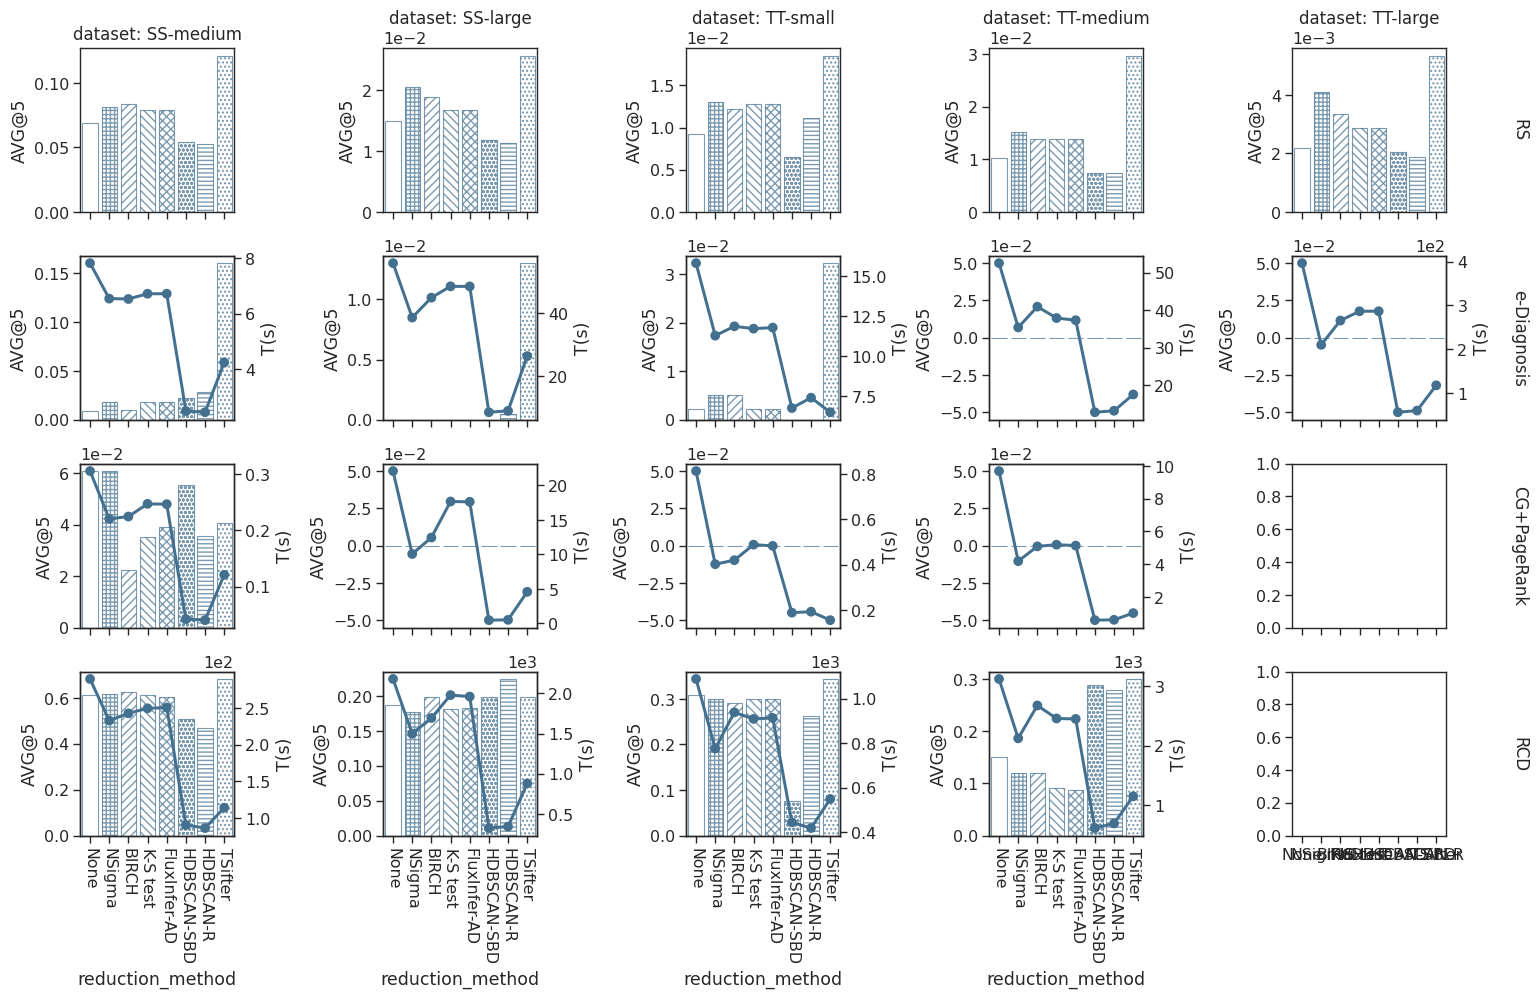

In [60]:
plot_grid(datasets[1:], loc_methods=LOC_METHODS_COMMON, col="dataset", row="localization_method")

/tmp/ipykernel_2218867/4253760079.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


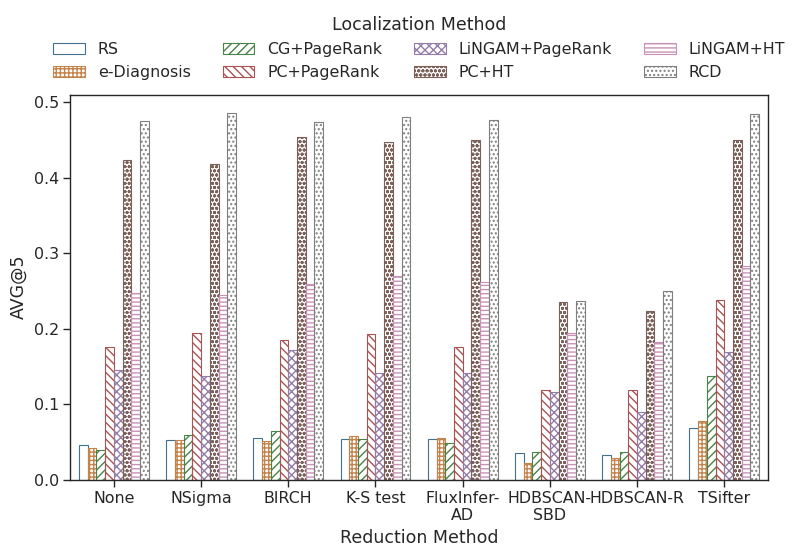

In [61]:
plot_combination("SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)

/tmp/ipykernel_2218867/4253760079.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


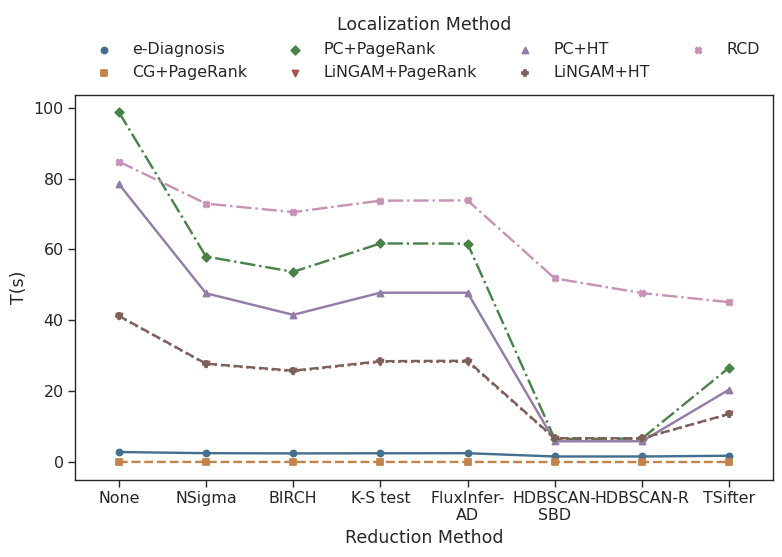

In [62]:
plot_combination("SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS[1:], plot_type="point")

In [63]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)

## Ablation Study

In [165]:
TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID = 894, 899
TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID + 1)]

In [288]:
def convert_to_step_name(phase: str) -> str:
    match phase:
        case "phase1":
            return "STEP0"
        case "phase2":
            return "STEP0-1"
        case "phase3":
            return "STEP0-3"
        case _:
            assert False, f"Unknown phase: {phase}"

def fetch_tsdr_metadata_by_phase(run_id: str) -> list[dict[str, str|float]]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return []
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (_, _, _, _, _):
                return []
                # assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        csv_path = f"/tmp/summary_by_phase-csv-{run_id}.csv"
        run["scores/summary_by_phase-csv"].download(destination=csv_path)
        summary_by_phase = pd.read_csv(csv_path)
        items = []
        for _, row in summary_by_phase.iterrows():  # skip phase1 simple filtering
            num_series = tuple([int(s) for s in row["num_series/total"].split("/")])
            num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]

            frr = row["reduction_rate_mean"]
            rfr = row["cause_metrics/recall_mandatory_mean"]
            rfp = row["cause_metrics/proportion_mandatory_mean"]
            elapsed_time = row["elapsed_time"]

            items.append({
                "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                "method": convert_to_step_name(row["phase"]),
                "phase": row["phase"],
                "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
                "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
            })
        return items

In [289]:
tsdr_phase_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_tsdr_metadata_by_phase)(run) for run in TSDR_ABLATION_RUN_IDS)
assert tsdr_phase_items is not None
tsdr_phase_items = sum(tsdr_phase_items, [])
tsdr_phase_items = [item for item in tsdr_phase_items if item]

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-894
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-898
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-897
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-895
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-899
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-896
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-894/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-898/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-895/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-897/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
http

In [290]:
steps = ["STEP0", "STEP0-1", "STEP0-3"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, steps], names=['Dataset', 'Step'],
)
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''],
)

tsdr_phase_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
    index=multi_level_indexes,
)

In [291]:
tsdr_phase_df

phase       FRR       RFR       RFP  elapsed_time  \
Dataset   Step                                                          
SS-small  STEP0    phase1  0.000000  1.000000  0.015521      0.276900   
          STEP0-1  phase2  0.213769  0.950000  0.019729      0.243784   
          STEP0-3  phase3  0.379029  0.925000  0.026659      0.226514   
SS-medium STEP0    phase1  0.000000  1.000000  0.023891      0.297339   
          STEP0-1  phase2  0.244541  0.964583  0.031460      0.358441   
          STEP0-3  phase3  0.478974  0.935000  0.046651      0.309034   
SS-large  STEP0    phase1  0.000000  1.000000  0.005023      0.445994   
          STEP0-1  phase2  0.254490  0.963167  0.006453      1.485795   
          STEP0-3  phase3  0.557006  0.851227  0.009771      0.976439   
TT-small  STEP0    phase1  0.000000  1.000000  0.003093      0.809967   
          STEP0-1  phase2  0.433013  0.928571  0.005002      0.919429   
          STEP0-3  phase3  0.603525  0.928571  0.007366      0.910940   
TT-medium STEP0    phase1  0.000000  1.000000  0.003438      0.890590   
          STEP0-1  phase2  0.430388  0.952381  0.005751      1.741464   
          STEP0-3  phase3  0.697163  0.943651  0.010825      1.551786   
TT-large  STEP0    phase1  0.000000  1.000000  0.000727      1.902519   
          STEP0-1  phase2  0.348138  0.976190  0.001092      9.436500   
          STEP0-3  phase3  0.714668  0.786281  0.001993      9.290333   

                   num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                   
SS-small  STEP0                      64                     64   
          STEP0-1                    50                     64   
          STEP0-3                    40                     64   
SS-medium STEP0                     185                    185   
          STEP0-1                   140                    185   
          STEP0-3                    96                    185   
SS-large  STEP0                    1347                   1347   
          STEP0-1                  1005                   1347   
          STEP0-3                   599                   1347   
TT-small  STEP0                     329                    329   
          STEP0-1                   187                    329   
          STEP0-3                   131                    329   
TT-medium STEP0                    1250                   1250   
          STEP0-1                   714                   1250   
          STEP0-3                   380                   1250   
TT-large  STEP0                    9343                   9343   
          STEP0-1                  6098                   9343   
          STEP0-3                  2677                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
SS-small  STEP0                  80                 1.000000  0.030802   
          STEP0-1                80                 0.950000  0.039017   
          STEP0-3                80                 0.925000  0.052391   
SS-medium STEP0                 499                 4.437500  0.047151   
          STEP0-1               499                 4.225000  0.061740   
          STEP0-3               499                 4.062500  0.090645   
SS-large  STEP0                6793                 6.800000  0.010018   
          STEP0-1              6793                 6.500000  0.012858   
          STEP0-3              6793                 5.600000  0.019424   
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.009976   
          STEP0-3               408                 0.928571  0.014668   
TT-medium STEP0                2857                 4.285714  0.006862   
          STEP0-1              2857                 4.142857  0.011464   
          STEP0-3              2857                 4.

In [292]:
import itertools

df_display = tsdr_phase_df[["FRR", "RFR", "RFP", "elapsed_time"]]
tsdr_s = df_display.style
tsdr_s.clear()
# tsdr_s.highlight_max(subset=(itertools.product(datasets, steps), ["FRR", "RFR", "RFP"]), props='textbf:--rwrap;')\
#     .highlight_min(subset=(itertools.product(datasets, steps), ["elapsed_time"]), props='textbf:--rwrap;')
tsdr_s.format({"RFP": '{:.4f}'}, precision=3)
tsdr_s.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

def highlight_max(s, props='textbf:--rwrap;'):
    is_max = s == s.max()
    return [props if v else '' for v in is_max]

def highlight_min(s, props='textbf:--rwrap;'):
    is_min = s == s.min()
    return [props if v else '' for v in is_min]

for dataset in datasets:
    tsdr_s.apply(highlight_max, subset=(itertools.product([dataset], steps), ["FRR", "RFR", "RFP"]), axis=0)
    tsdr_s.apply(highlight_min, subset=(itertools.product([dataset], steps), ["elapsed_time"]), axis=0)
print(tsdr_s.to_latex(hrules=True))

\begin{tabular}{llrrrr}
\toprule
 &  & FRR & RFR & RFP & elapsed_time \\
Dataset & Step &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{SS-small} & STEP0 & 0.000 & \textbf{1.000} & 0.0155 & 0.277 \\
 & STEP0-1 & 0.214 & 0.950 & 0.0197 & 0.244 \\
 & STEP0-3 & \textbf{0.379} & 0.925 & \textbf{0.0267} & \textbf{0.227} \\
\multirow[c]{3}{*}{SS-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.0239 & \textbf{0.297} \\
 & STEP0-1 & 0.245 & 0.965 & 0.0315 & 0.358 \\
 & STEP0-3 & \textbf{0.479} & 0.935 & \textbf{0.0467} & 0.309 \\
\multirow[c]{3}{*}{SS-large} & STEP0 & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.446} \\
 & STEP0-1 & 0.254 & 0.963 & 0.0065 & 1.486 \\
 & STEP0-3 & \textbf{0.557} & 0.851 & \textbf{0.0098} & 0.976 \\
\multirow[c]{3}{*}{TT-small} & STEP0 & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.810} \\
 & STEP0-1 & 0.433 & 0.929 & 0.0050 & 0.919 \\
 & STEP0-3 & \textbf{0.604} & 0.929 & \textbf{0.0074} & 0.911 \\
\multirow[c]{3}{*}{TT-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.0034 & \

In [265]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product([ss_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [ss_datasets, metrics], names=['', ''],
    )
    ss_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes,
    )
    df_pivot = ss_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(ss_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(ss_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(ss_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(ss_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())

SS-small                               SS-medium            \
                  FRR    RFR       RFP elapsed_time       FRR       RFR   
Step                                                                      
STEP0        0.000000  1.000  0.015521     0.276900  0.000000  1.000000   
STEP1        0.213769  0.950  0.019729     0.243784  0.244541  0.964583   
STEP2+STEP3  0.379029  0.925  0.026659     0.226514  0.478974  0.935000   

                                    SS-large                                   
                  RFP elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                                           
STEP0        0.023891     0.297339  0.000000  1.000000  0.005023     0.445994  
STEP1        0.031460     0.358441  0.254490  0.963167  0.006453     1.485795  
STEP2+STEP3  0.046651     0.309034  0.557006  0.851227  0.009771     0.976439

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0155 & 0.277 & 0.000 & \textbf{1.000} & 0.0239 & \textbf{0.297} & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.446} \\
STEP1 & 0.214 & 0.950 & 0.0197 & 0.244 & 0.245 & 0.965 & 0.0315 & 0.358 & 0.254 & 0.963 & 0.0065 & 1.486 \\
STEP2+STEP3 & \textbf{0.379} & 0.925 & \textbf{0.0267} & \textbf{0.227} & \textbf{0.479} & 0.935 & \textbf{0.0467} & 0.309 & \textbf{0.557} & 0.851 & \textbf{0.0098} & 0.976 \\
\end{tabular}



In [259]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [tt_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [tt_datasets, metrics], names=['', ''])
    tt_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes)
    display(tt_tsdr_df)
    df_pivot = tt_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(tt_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(tt_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(tt_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(tt_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())

phase       FRR       RFR       RFP  elapsed_time  \
Dataset   Step                                                              
TT-small  STEP0        phase1  0.000000  1.000000  0.003093      0.809967   
          STEP1        phase2  0.433013  0.928571  0.005002      0.919429   
          STEP2+STEP3  phase3  0.603525  0.928571  0.007366      0.910940   
TT-medium STEP0        phase1  0.000000  1.000000  0.003438      0.890590   
          STEP1        phase2  0.430388  0.952381  0.005751      1.741464   
          STEP2+STEP3  phase3  0.697163  0.943651  0.010825      1.551786   
TT-large  STEP0        phase1  0.000000  1.000000  0.000727      1.902519   
          STEP1        phase2  0.348138  0.976190  0.001092      9.436500   
          STEP2+STEP3  phase3  0.714668  0.786281  0.001993      9.290333   

                       num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                       
TT-small  STEP0                         329                    329   
          STEP1                         187                    329   
          STEP2+STEP3                   131                    329   
TT-medium STEP0                        1250                   1250   
          STEP1                         714                   1250   
          STEP2+STEP3                   380                   1250   
TT-large  STEP0                        9343                   9343   
          STEP1                        6098                   9343   
          STEP2+STEP3                  2677                   9343   

                       num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                               
TT-small  STEP0                     408                 1.000000  0.006176   
          STEP1                     408                 0.928571  0.009976   
          STEP2+STEP3               408                 0.928571  0.014668   
TT-medium STEP0                    2857                 4.285714  0.006862   
          STEP1                    2857                 4.142857  0.011464   
          STEP2+STEP3              2857                 4.095238  0.021519   
TT-large  STEP0                   57697                 6.785714  0.001454   
          STEP1                   57697                 6.642857  0.002184   
          STEP2+STEP3             57697                 5.428571  0.003981   

                        rs_ac@5  rs_avg@5  
Dataset   Step                             
TT-small  STEP0        0.015367  0.009239  
          STEP1        0.024733  0.014895  
          STEP2+STEP3  0.036201  0.021845  
TT-medium STEP0        0.017057  0.010260  
          STEP1        0.028381  0.017103  
          STEP2+STEP3  0.052832  0.031956  
TT-large  STEP0        0.003632  0.002180  
          STEP1        0.005450  0.003272  
          STEP2+STEP3  0.009919  0.005960

TT-small                                  TT-medium            \
                  FRR       RFR       RFP elapsed_time       FRR       RFR   
Step                                                                         
STEP0        0.000000  1.000000  0.003093     0.809967  0.000000  1.000000   
STEP1        0.433013  0.928571  0.005002     0.919429  0.430388  0.952381   
STEP2+STEP3  0.603525  0.928571  0.007366     0.910940  0.697163  0.943651   

                                    TT-large                                   
                  RFP elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                                           
STEP0        0.003438     0.890590  0.000000  1.000000  0.000727     1.902519  
STEP1        0.005751     1.741464  0.348138  0.976190  0.001092     9.436500  
STEP2+STEP3  0.010825     1.551786  0.714668  0.786281  0.001993     9.290333

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.810} & 0.000 & \textbf{1.000} & 0.0034 & \textbf{0.891} & 0.000 & \textbf{1.000} & 0.0007 & \textbf{1.903} \\
STEP1 & 0.433 & 0.929 & 0.0050 & 0.919 & 0.430 & 0.952 & 0.0058 & 1.741 & 0.348 & 0.976 & 0.0011 & 9.437 \\
STEP2+STEP3 & \textbf{0.604} & 0.929 & \textbf{0.0074} & 0.911 & \textbf{0.697} & 0.944 & \textbf{0.0108} & 1.552 & \textbf{0.715} & 0.786 & \textbf{0.0020} & 9.290 \\
\end{tabular}

